In [1]:
#copied from traffic_demo.py
%matplotlib inline


In [2]:
#pid,tz = 23618402, 'Europe/Berlin'

pid,tz = 23602975, 'Europe/Amsterdam'

#pid,tz = 20095971,'America/Chicago'
#pid,tz = 20095972,'America/Chicago'

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]


In [4]:
import os,sys
from hmctools.segment import TopologySegment,HmcPartition
import pytz,datetime

import numpy as np
import pandas as pd

In [5]:
def get_traffic_speeds(pid,sid,orient,offset ,tzstring):

    segment = TopologySegment(pid,sid)

    live_traffic_data = segment.get_live_traffic_speed(offset,orient)
    if live_traffic_data is None:
        return None,None
    live_speed = live_traffic_data[2]
    live_time = live_traffic_data[0]
    if live_traffic_data[1]!=0:
        print('Careful - there is a nonzero value for update time!',live_traffic_data[1])

    #need to convert UTC timestamp to local datetime
    live_utc = datetime.datetime.fromtimestamp(live_time, pytz.timezone('UTC') )
    local_tz = pytz.timezone(tzstring) # e.g. 'Europe/Berlin'
    local_time = live_utc.astimezone(local_tz)

    print("Local time ",local_time)
    pattern_speed = segment.get_historical_traffic_speed(offset,orient, local_time )
    print("Historical/live speed:",pattern_speed,live_speed)

    return pattern_speed,live_speed


In [6]:
def main(pid,tzstring):

    historical_speeds = []
    live_speeds = []
    segids = []
    dots = []
    seglens= []
    segfcs = []
    #just use offset=0.5 of each segment
    offset = 0.5

    partition = HmcPartition(pid)
    all_segment_ids = partition.get_all_segment_ids()
     
    nexcept = 0
    nok = 0
        
    for iseg,seg in enumerate(all_segment_ids):
        segment = TopologySegment(pid,seg)
        aa = segment.accessible_by(offset)
        dot = segment.travel_direction(offset)
        if not aa:
            continue
        if dot=='BOTH':
            dot = ['FORWARD','BACKWARD']
        else:
            dot = [dot]
        segment_length = segment.length()
        fcstring = segment.functional_class(offset)
        if fcstring is not None:
            fc = int( fcstring[-1] )
        else:
            fc =0
        for dd in dot:

            try:
                hist,live = get_traffic_speeds( pid,seg,dd,offset,tzstring )
                historical_speeds.append(hist)
                live_speeds.append(live)
                segids.append(seg)
                dots.append(dd)
                seglens.append(segment_length)
                segfcs.append(fc)
                
                nok += 1
            except:
                nexcept +=1
                #print('warning: exception caught')
        #if iseg>10:
        #    break
    return pd.DataFrame( {'segment':segids,'direction':dots,'historical':historical_speeds,'live':live_speeds,'FC':segfcs,'length':seglens}  )



In [7]:

df = main(pid, tz)
print(df)

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 15 21.49
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 33 24.77
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 17.06
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 26 23.58
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 20.93
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 40 28.49
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 34 23.25
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 20 40.98
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 23.47
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 41 28.83
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 18 21.49
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 17 27.67
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 28.99
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 25 17.77
Local time  

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 23 25.51
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 17.92
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 22 18.38
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 24 14.72
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 34 25.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 33 28.52
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 19.36
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 16 14.81
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 12 15.18
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 18.04
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 18 14.86
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 35 22.93
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 25 28.83
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 27 17.94
Local time  20

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 25 15.18
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 26 12.48
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 24 14.72
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 28 15.38
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 24.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 39 27.15
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 18 24.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 27.15
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 27.15
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 14 24.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 15 15.18
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 39 16.45
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 23.17
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 27.24
Local time

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 32 14.51
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 24 14.51
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 17 22.27
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 32 26.04
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 18 14.08
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 23.74
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 20 19.19
WARNING in get_live_traffic_speed; there are too many matches (will just use the first one) 2 23602975 93750354 FORWARD 0.5 ['E3817N55245', 'E3817P55333']
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 29 15.34
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 22 29.4
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 30 22.63
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 28 15.34
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 26 19.19
Loca

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 38 28.18
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 27 25.88
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 27 23.51
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 13 15.18
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 32 25.81
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 24 16.57
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 16 15.34
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 26 17.77
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 27.24
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 17.92
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 15 18.38
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 17 16.57
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 10 15.69
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 39 28.83
WARNING in get_l

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 22 18.3
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 37 27.85
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 14 18.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 25 23.51
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 29 44.35
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 36.13
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 46 36.04
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 26 17.94
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 33 20.0
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 22.98
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 36.13
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 49 36.04
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 25 14.66
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 22 28.67
Local time  2020

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 19 37.86
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 30.89
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 49 37.64
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 22 25.51
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 27 25.64
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 23 29.12
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 25.81
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 28.03
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 31 27.65
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 27 25.7
WARNING in get_live_traffic_speed; there are too many matches (will just use the first one) 2 23602975 154241532 BACKWARD 0.5 ['E3817P46543', 'E3817P55269']
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 39.09
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 16 15.69


Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 35 21.49
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 30 38.45
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 49 23.73
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 16 20.93
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 23.58
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 12 16.62
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 25.64
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 28 22.27
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 29 21.49
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 19 25.54
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 100 103.79
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 21.98
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 27.85
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 21 14.51
Local time  20

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 29 26.32
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 48.69
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 35 29.14
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 66 77.43
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 40 40.98
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 14 21.9
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 31 40.44
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 27.15
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 29 24.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 100 100.98
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 20 21.9
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 33 31.24
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 29.14
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 44 30.95
Local time  20

WARNING in get_live_traffic_speed; there are too many matches (will just use the first one) 2 23602975 181451050 FORWARD 0.5 ['E3817P55276', 'E3817P38017']
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 52.18
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 10 17.99
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 37 17.2
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 30 15.69
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 30.71
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 41 28.41
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 17.06
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 33 24.77
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 41 23.58
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 20.93
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 99 108.66
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 95 96.9

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 38 28.41
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 14 16.45
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 23.17
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 28.18
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 37 29.52
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 37 28.11
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 99 99.28
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 19 21.9
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 42 25.81
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 17 30.21
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 100 111.19
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 30 20.37
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 60 18.16
WARNING in get_live_traffic_speed; there are too many matches (will just use the firs

WARNING in get_live_traffic_speed; there are too many matches (will just use the first one) 2 23602975 557477496 FORWARD 0.5 ['E3817N38012', 'E3817N55275']
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 97 101.01
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 77 85.88
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 100 103.79
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 32 18.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 29 27.15
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 24.55
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 39 41.08
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 29 23.73
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 37 30.21
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 50.16
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 40 16.45
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 26.

Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 29.4
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 30.21
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 50 30.21
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: None 30.21
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 38 29.14
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 24 21.98
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 37 21.98
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 45 25.88
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 100 99.68
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 35 37.64
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 30 28.83
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 38 30.21
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 19 30.21
Local time  2020-07-15 14:53:02+02:00
Historical/live speed: 31 37.64
Local time  2020-0

In [8]:
df.dropna(subset=['historical','live','FC','length'],inplace=True)

df['residual']=df['live']-df['historical']
df['km']=df['length']/1000.0
df['weighted_residual'] = df['residual']*df['km']
print( df['FC'].unique() )
maxval = max( df['residual'].max(), abs(df['residual'].min())  )
colmap = {1:'k',2:'r',3:'g',4:'b',5:'m'}
binning = np.linspace(-maxval,maxval,26)


[3 2 4 5 1]


FC1: length-weighted mean = 4.603708115732072
FC2: length-weighted mean = -2.443175791452024
FC3: length-weighted mean = -5.513738613285189
FC4: length-weighted mean = -5.653920845584172


Text(0, 0.5, 'Total km')

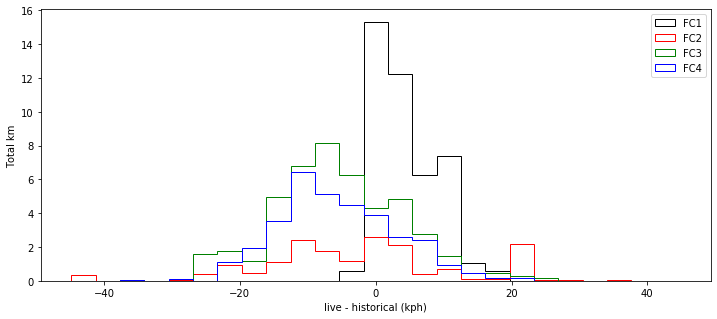

In [9]:
groups = df.groupby('FC')
for ifc, gdata in groups:
    if ifc==5:
        continue
    plt.hist( gdata['residual'],bins=binning,color=colmap[ifc],histtype='step',label='FC'+str(ifc),weights=gdata['km'])
    #ax[1].hist( gdata['residual'],bins=binning,color=colmap[ifc],histtype='step',label='FC'+str(ifc),normed=True)
    print("FC"+str(ifc)+': length-weighted mean = '+str( gdata['weighted_residual'].sum() /gdata['km'].sum() ))

#for i in range(2):
plt.legend()
plt.xlabel('live - historical (kph)')
plt.ylabel('Total km')


In [10]:
df.head()

,segment,direction,historical,live,FC,length,residual,km,weighted_residual
4,76333167,BACKWARD,15.0,21.49,3,24.51817,6.49,0.024518,0.159123
46,76689661,FORWARD,33.0,24.77,2,29.05034,-8.23,0.029050,-0.239084
65,76780856,FORWARD,26.0,23.58,4,39.12890,-2.42,0.039129,-0.094692
87,76951990,FORWARD,40.0,28.49,4,27.27011,-11.51,0.027270,-0.313879
112,77091139,BACKWARD,34.0,23.25,4,34.50149,-10.75,0.034501,-0.370891


In [11]:
from nagini.utils.tiling import bounding_box_from_tile_id
clat = bounding_box_from_tile_id(pid).center().latitude
clon = bounding_box_from_tile_id(pid).center().longitude

In [12]:
cmap_name = 'RdYlGn'#'seismic'
cm = matplotlib.cm.get_cmap(cmap_name)
max_abs_res = max( np.abs( df['residual'] ))


In [13]:
def get_color(val,max_abs_residual):
    norm = matplotlib.colors.Normalize(vmin=-max_abs_residual, vmax=max_abs_residual)
    ctuple = cm(norm(val),bytes=True)
    cstr = '#'
    for i in range(3):
        cstr+= hex(ctuple[i])[2:].zfill(2)
    return cstr
print(max_abs_res)

44.82


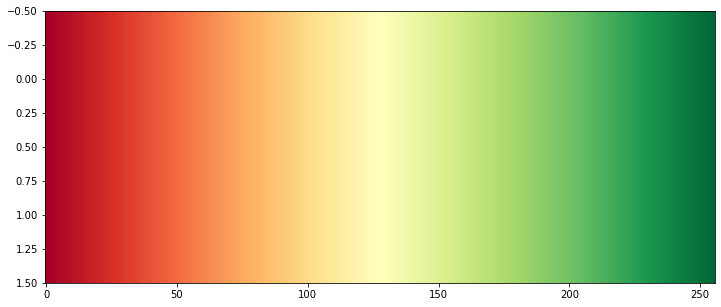

In [14]:
norm=matplotlib.colors.Normalize(vmin=-max_abs_res, vmax=max_abs_res)
gradient = np.linspace(-max_abs_res, max_abs_res, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(norm(gradient), aspect='auto', cmap=cm)

In [15]:
import nagini
from ipyleaflet import Map, Polyline
hls = nagini.resource('hls')

mymap = hls.map(center=[clat, clon], zoom=12)

for idx,row in df.iterrows():
    sid = row['segment']
    geom = [ list(q) for q in TopologySegment(pid,sid).shape_points() ]
    #print(sid,geom)
    c = get_color(row['residual'],max_abs_res)
    pl = Polyline(locations = geom,color=c,fill=False)
    mymap.add_layer(pl)


In [16]:
from ipyleaflet import FullScreenControl
mymap.add_control(FullScreenControl())
mymap

LeafletMap(basemap={'url': 'https://1.base.maps.ls.hereapi.com/maptile/2.1/maptile/newest/normal.day/{z}/{x}/{…